In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
def plot_target_distribution(target):
    """Plot the target variable distribution."""
    target_distribution = target.value_counts()
    print('Class Distribution:\n', target_distribution)
    target_distribution.plot(kind='bar', title='Target Class Distribution')
    plt.show()

def resample_data(X, y, random_state=20):
    """Resample dataset to address class imbalance using SMOTE."""
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original class distribution: {Counter(y)}")
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    return X_resampled, y_resampled

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model with performance metrics."""
    # Cross-validation score
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    print(f"{model_name} Cross-validation score: {cv_score:.2%}")

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate on test set
    test_score = model.score(X_test, y_test)
    print(f"{model_name} Test set score: {test_score:.2%}")

    # Predictions
    y_pred = model.predict(X_test)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix)
    plot_confusion_matrix(conf_matrix, model_name)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Precision: {precision:.2f}")
    print(f"{model_name} Recall: {recall:.2f}")
    print(f"{model_name} AUC: {auc:.2f}")

    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": auc
    }

def plot_confusion_matrix(conf_matrix, model_name):
    """Plot a confusion matrix as a heatmap."""
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [8]:
data = pd.read_csv('/content/drive/MyDrive/ECS_271/cleaned_data_2.csv')

In [9]:
feature_set= ['race_1','race_2','race_3','race_4','gender_1','age','admission_type_id_3',
       'admission_type_id_4','admission_type_id_5','discharge_disposition_id_2',
        'discharge_disposition_id_7','discharge_disposition_id_10','discharge_disposition_id_18','discharge_disposition_id_19',
        'discharge_disposition_id_20','discharge_disposition_id_27','discharge_disposition_id_28','admission_source_id_4', 'admission_source_id_8',
        'admission_source_id_9','admission_source_id_11','num_lab_procedures','number_diagnoses', 'max_glu_serum_1.0', 'A1Cresult_1',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
        'num_med', 'primary_diag_1','primary_diag_2','primary_diag_3','primary_diag_4','primary_diag_5','primary_diag_6','primary_diag_7','primary_diag_8',
        'number_emergency_log','patient_service_log', 'time_in_hospital_log', 'med_change_log',
       'num_procedures_log', 'number_outpatient_log', 'num_medications_log',
       'number_inpatient_log']
features = data[feature_set]
target = data['readmitted']

Class Distribution:
 readmitted
0    79512
1     9607
Name: count, dtype: int64


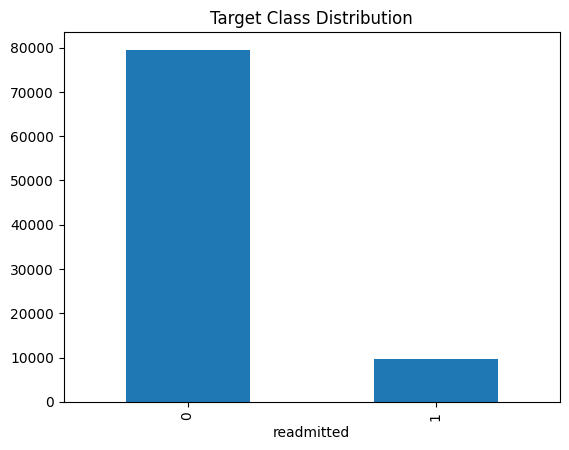

Original class distribution: Counter({0: 71569, 1: 8638})
Resampled class distribution: Counter({0: 71569, 1: 71569})


In [10]:

# Plot target variable distribution
plot_target_distribution(target)

# Split the dataset into train-test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0)

# Resample training data to address class imbalance
X_resampled, y_resampled = resample_data(X_train, y_train)

# Save the resampled dataset to a CSV file
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=features.columns), pd.DataFrame(y_resampled, columns=['readmitted'])], axis=1)
resampled_data.to_csv('./smote_data.csv', index=False)

# Further split resampled data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.1, random_state=0
)

In [11]:
models = {
    "Logistic Regression": LogisticRegression(fit_intercept=True, penalty='l2', random_state=0),
    "Decision Tree": DecisionTreeClassifier(max_depth=28, criterion="entropy", min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=28, min_samples_split=10, criterion='entropy', random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=0),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=10, random_state=0)
}


--- Evaluating Logistic Regression ---


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Cross-validation score: 74.06%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Test set score: 75.38%
Logistic Regression Confusion Matrix:
 [[5666 1445]
 [2079 5124]]


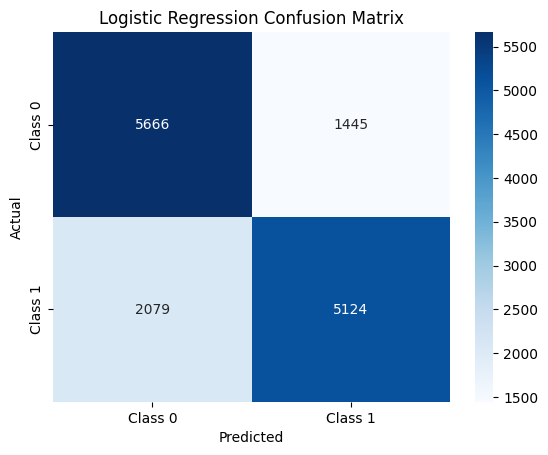

Logistic Regression Accuracy: 0.75
Logistic Regression Precision: 0.78
Logistic Regression Recall: 0.71
Logistic Regression AUC: 0.75

--- Evaluating Decision Tree ---
Decision Tree Cross-validation score: 88.70%
Decision Tree Test set score: 89.11%
Decision Tree Confusion Matrix:
 [[6432  679]
 [ 880 6323]]


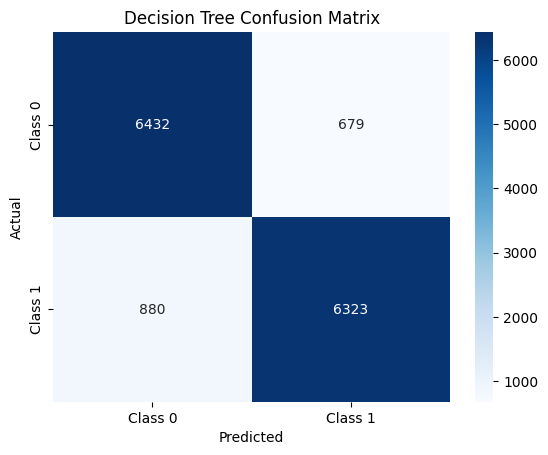

Decision Tree Accuracy: 0.89
Decision Tree Precision: 0.90
Decision Tree Recall: 0.88
Decision Tree AUC: 0.89

--- Evaluating Random Forest ---


In [ ]:
model_metrics = []
for model_name, model in models.items():
    print(f"\n--- Evaluating {model_name} ---")
    metrics = evaluate_model(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, model_name)
    model_metrics.append(metrics)
metrics_df = pd.DataFrame(model_metrics)
print("\nModel Performance Summary:")
print(metrics_df)

# Plot a bar chart for Accuracy
metrics_df.plot(x='model', y='accuracy', kind='bar', legend=False, title="Model Accuracy", figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Comparative Analysis for Metrics
def plot_comparative_metrics(metrics_df, metrics=['accuracy', 'precision', 'recall']):
    """
    Plot bar charts to compare accuracy, precision, and recall across models.
    """
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='model', y=metric, data=metrics_df, palette='viridis')
        plt.title(f'Model Comparison: {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)  # Assuming all metrics are between 0 and 1
        plt.tight_layout()
        plt.show()

# Plot metrics
plot_comparative_metrics(metrics_df, metrics=['accuracy', 'precision', 'recall'])
